<a href="https://colab.research.google.com/github/Anjali-Shalimar/Movie-Recommendation-Engine/blob/master/Capstone_DC_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Required Packages

In [50]:
# Importing required packages
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import re
import nltk
from nltk.tokenize import word_tokenize
import plotly  as py
import plotly.offline as pyo
from plotly.offline import iplot
import plotly.graph_objs as ob
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#Authorizing data upload from google drive

In [51]:

#@title Google drive mount
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [52]:
# Reading the data
credits = pd.read_csv("/content/gdrive/My Drive/Data Mining/credits.csv")
movies_meta = pd.read_csv("/content/gdrive/My Drive/Data Mining/movies_metadata.csv")
ratings =pd.read_csv("/content/gdrive/My Drive/Data Mining/ratings_small.csv")


In [ ]:
movies_eda.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'userId', 'rating',
       'timestamp'],
      dtype='object')

# Data Wrangling


Merging the data


In [38]:
movies_meta['id'] = movies_meta['id'].astype(str)
credits['id'] = credits['id'].astype(str)
ratings.rename(columns = {'movieId':'id'}, inplace = True) 
ratings['id'] = ratings['id'].astype(str)
movies_meta = movies_meta.merge(credits, how='inner',on='id')
movies_eda = movies_meta.merge(ratings, how='inner',on='id')
movies_meta.head()
movies_meta = movies_meta [1 :20000][:]

#Exploratory Data Analysis

## Getting the main genre across each movie rating

In [41]:
movies_eda['genres'] = movies_eda['genres'].apply(literal_eval)
def ret_top(a):
    if isinstance(a, list):
        genre_type = [x['name'] for x in a]
        genre_nam = genre_type[:1]
        return genre_nam

    return []


movies_eda['genres']=movies_eda['genres'].apply(ret_top)
movies_eda['genres'] = movies_eda['genres'].astype(str)



In [42]:
movies_eda['genres'].head()


0    ['Action']
1    ['Action']
2    ['Action']
3    ['Action']
4    ['Action']
Name: genres, dtype: object

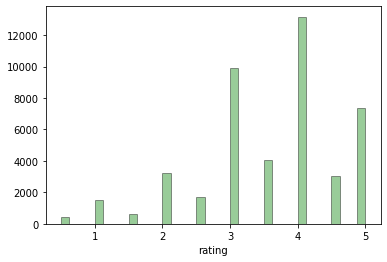

In [43]:
# Getting distribution of ratings 
sns.distplot(movies_eda['rating'], hist=True, kde=False, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'}) 

# value counts by genre
#movies_eda['genres'].value_counts()


In [10]:
movies_eda['rating'].max()

5.0

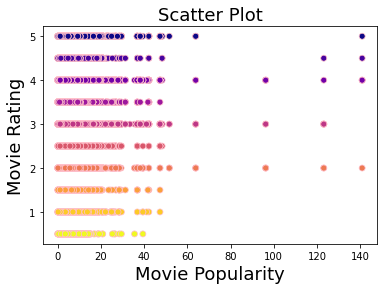

In [24]:
# Sctter plot of Movie popularity vs. rating
j = sns.scatterplot(movies_eda['popularity'],movies_eda['rating'],hue=movies_eda['rating'], edgecolor='pink',palette="plasma_r")
plt.xlabel('Movie Popularity', fontsize=18)
plt.ylabel('Movie Rating', fontsize=18)
plt.title("Scatter Plot", fontsize=18)
plt.legend().set_visible(False)
plt.show()


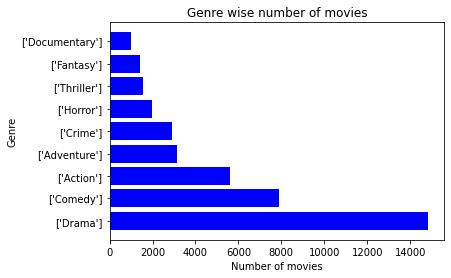

In [45]:
# Top 10 genres by movie count
gen_count = pd.DataFrame(movies_eda['genres'].value_counts()).reset_index()
gen_count.columns = ['genre', 'num_movies']
gen_count = gen_count.head(9)
y = gen_count['genre'].unique().astype(str)
plt.barh(y, gen_count['num_movies'], color='blue')
plt.ylabel("Genre")
plt.xlabel("Number of movies")
plt.title("Genre wise number of movies")

#plt.yticks(gen_count['genre'], gen_count['num_movies'])

plt.show()

In [49]:
# Top 10 Genre average rating
gen_rating = pd.DataFrame(movies_eda.groupby('genres')['rating'].mean()).reset_index()
gen_rating.columns = ['genre', 'avg_rating']
gen_rating = gen_rating.sort_values()
gen_rating = gen_rating.head(10)
y = gen_rating['genre'].unique().astype(str)
plt.barh(y, gen_rating['avg_rating'], color='blue')
plt.ylabel("Genre")
plt.xlabel("Average Rating")
plt.title("Genre wise average rating ")

NameError: ignored

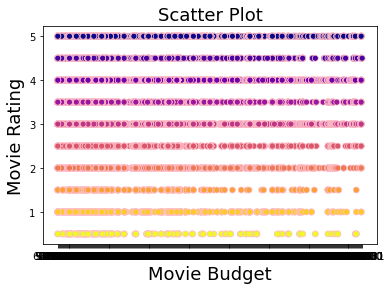

In [47]:
a = sns.scatterplot(movies_eda['budget'],movies_eda['rating'],hue=movies_eda['rating'], edgecolor='pink',palette="plasma_r")
plt.xlabel('Movie Budget', fontsize=18)
plt.ylabel('Movie Rating', fontsize=18)
plt.title("Scatter Plot", fontsize=18)
plt.legend().set_visible(False)
plt.show()

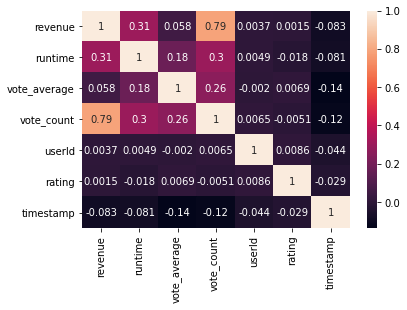

In [28]:
# Correlation Matrix 
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
data_frame = pd.DataFrame(movies_eda)

cor_mat = data_frame.corr()
sn.heatmap(cor_mat, annot=True)
plt.show()

# Content Based Recommender System

The section looks into recommending movies, based on cosine similarity scores between movie descriptions.

### TF -IDF vectorization on movie description


In [51]:
movies_meta['overview'] = movies_meta['overview'].astype(str)
#Punctuation
movies_meta['overview'] = movies_meta['overview'].apply(lambda x : re.sub(r'[^a-zA-Z\s]','', x ) )

#Removing digits 
movies_meta['overview'] = movies_meta['overview'].apply(lambda x :re.sub("\d+", "", x))

#Replacing Nan
movies_meta['overview'] = movies_meta['overview'].fillna('')

#Converting to lower case
movies_meta['overview'] = movies_meta['overview'].apply(lambda x : x.lower())

#Removing stopwords
tf_idf = TfidfVectorizer(stop_words='english')
#Creating TF-IDF matrix 
tfidf_mat = tf_idf.fit_transform(movies_meta['overview'])



### Computing Cosine Similarity Score for the TF-IDF Matrix

In [52]:
cosine_score = linear_kernel(tfidf_mat, tfidf_mat)

In [ ]:

movies_meta.title.unique()

array(['Jumanji', 'Grumpier Old Men', 'Waiting to Exhale', ...,
       'Two in the Wave',
       'Lotte Reiniger: Homage to the Inventor of the Silhouette Film',
       "RKO Production 601: The Making of 'Kong, the Eighth Wonder of the World'"],
      dtype=object)

### User Defined function to output similar movie IDs based on cosine similarity


In [ ]:
# duplicates are removed to get the indices corresponding to each movie title

movies_meta = movies_meta.drop_duplicates(subset='title')
ind = pd.Series(movies_meta.index, index=movies_meta['title'])

def recommend_movie(title,num, cosine=cosine_score):
  title_ind = ind[title]
  sim_movie_score = list(enumerate(cosine[title_ind]))
  sim_movie_score = sorted(sim_movie_score, key=lambda a: a[1], reverse=True)
  sim_movie_score = sim_movie_score[1:num]
  sim_movie_ind = [x[0] for x in sim_movie_score]
  return movies_meta['title'].iloc[sim_movie_ind]

In [ ]:
# Test case
recommend_movie("Captain America",num=5)

18723    The Price of Forgiveness
19760         Men Do what Men Can
3323                 Death Wish 3
15494                Grande école
Name: title, dtype: object

## Single Value Decomposition Recommender System

In [8]:
!pip install surprise
!pip install evaluate
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
dat_read = Reader()
ratings_dat =pd.read_csv("/content/gdrive/My Drive/Data Mining/ratings_small.csv")
ratings_dat.head()
svd_read = Reader()
svd_dat = Dataset.load_from_df(ratings_dat[['userId', 'movieId', 'rating']], svd_read)
svd_function = SVD()
cross_validate(svd_function, svd_dat, measures=['RMSE'], cv=10)




{'fit_time': (5.417065382003784,
  5.426379203796387,
  5.39730167388916,
  5.461868524551392,
  5.54870867729187,
  5.419975996017456,
  5.401140928268433,
  5.363962650299072,
  5.38405442237854,
  5.382412910461426),
 'test_rmse': array([0.88495299, 0.89204699, 0.89641149, 0.89352776, 0.90898886,
        0.87433738, 0.87887033, 0.88850501, 0.90647825, 0.89011574]),
 'test_time': (0.06982183456420898,
  0.14453792572021484,
  0.06897425651550293,
  0.0774996280670166,
  0.07196497917175293,
  0.06846451759338379,
  0.1530895233154297,
  0.06804871559143066,
  0.06777095794677734,
  0.06757569313049316)}

In [21]:
svd_train = svd_dat.build_full_trainset()
svd_function.fit(svd_train)
a=svd_function.predict(1,302,3)
a[3]


2.7437631144089973

In [47]:
b[0]

0

In [55]:
#movie_id = ratings_dat['movieId'].unique()
#a = len(movie_id)
import itertools
def get_svd_rating(user_id, movie_id):
  mov_rating=[]
  a = svd_function.predict(user_id,movie_id,3)
  mov_rating=a[3]
  return mov_rating

# Getting movie rating for user id 2 and movie id 400
get_svd_rating(2,400)


3.4480917617403253